In [1]:
%load_ext autoreload
%autoreload 2
import os
import cv2
import PIL
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from meter_digits_recognizer import Net

In [2]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(1)

# Split training and testing data

In [3]:
dataset_dir = "images"
input_filenames = []
input_labels = []
for sub_dir in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]:
    for fn in os.listdir(os.path.join(dataset_dir, sub_dir)):
        if not fn.endswith(".jpg"):
            continue
        img_file = os.path.join(dataset_dir, sub_dir, fn)
        input_filenames.append(img_file)
        input_labels.append(int(sub_dir))
indices = np.arange(len(input_filenames))
np.random.shuffle(indices)
split_index = int(0.2 * len(indices))
test_indices, train_indices = indices[:split_index], indices[split_index:]
print("Test %d, train %d" % (len(test_indices), len(train_indices)))

Test 170, train 683


# Init datasets and dataloaders

In [4]:
class DigitsDataset(Dataset):
  
    def __init__(self, indices, input_filenames, input_labels, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        for i in indices:
            img = cv2.imread(input_filenames[i])
            resized = cv2.resize(img, (20, 32), interpolation=cv2.INTER_LINEAR)
            self.images.append(resized)
            self.labels.append(input_labels[i])
        print("Loaded %d images" % (len(self.images)))
                
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

trainset = DigitsDataset(train_indices, input_filenames, input_labels, transform=Net.train_transform)
testset = DigitsDataset(test_indices, input_filenames, input_labels, transform=Net.test_transform)

batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Loaded 683 images
Loaded 170 images


# Visualize training data

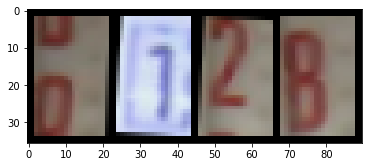

   10     1     2     8


In [5]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(cv2.cvtColor(np.transpose(npimg, (1, 2, 0)), cv2.COLOR_BGR2RGB))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j].item() for j in range(4)))

# Train

In [6]:
def calculate_accuracy(loader):
    correct, total = 0, 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            for img, label in zip(images, labels):
                output = net(img.unsqueeze(0))
                predicted = torch.max(output, 1).indices[0].item()
                total += 1
                if predicted == label:
                    correct += 1
    return correct, total

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: %s" % (device))

best_model = None
best_model_accuracy = -1.0
net = Net()
net.to(device)
summary(net, input_size=(3, 32, 20))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

running_loss = 0.0
start_time = time.time()
for epoch in range(150):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print("Epoch %d, batch %d, runnig_loss %.3f, loss %.3f" % (epoch, i, running_loss, loss.item()))
    running_loss = 0
    
    correct, total = calculate_accuracy(trainloader)
    print("  Train: Correct %d, Total %d, Accuracy %.3f" % (correct, total, float(correct) / total))
    
    correct, total = calculate_accuracy(testloader)
    test_accuracy = float(correct) / total
    print("  Test: Correct %d, Total %d, Accuracy %.3f" % (correct, total, test_accuracy))
    if test_accuracy > best_model_accuracy:
        print("Saving new best model")
        best_model_accuracy = test_accuracy
        best_model = deepcopy(net.state_dict())

    #if epoch == 50:
    #    print("Reducing learning rate..")
    #    optimizer.lr = 5e-4      
print("Total time: %.3f" % (time.time() - start_time))

 147, Accuracy 0.891
Epoch 15, batch 146, runnig_loss 26.733, loss 0.246
  Train: Correct 555, Total 588, Accuracy 0.944
  Test: Correct 132, Total 147, Accuracy 0.898
Epoch 16, batch 146, runnig_loss 16.914, loss 0.310
  Train: Correct 574, Total 588, Accuracy 0.976
  Test: Correct 133, Total 147, Accuracy 0.905
Saving new best model
Epoch 17, batch 146, runnig_loss 35.340, loss 0.014
  Train: Correct 554, Total 588, Accuracy 0.942
  Test: Correct 133, Total 147, Accuracy 0.905
Epoch 18, batch 146, runnig_loss 21.664, loss 0.069
  Train: Correct 555, Total 588, Accuracy 0.944
  Test: Correct 127, Total 147, Accuracy 0.864
Epoch 19, batch 146, runnig_loss 18.274, loss 0.001
  Train: Correct 568, Total 588, Accuracy 0.966
  Test: Correct 128, Total 147, Accuracy 0.871
Epoch 20, batch 146, runnig_loss 20.259, loss 0.021
  Train: Correct 564, Total 588, Accuracy 0.959
  Test: Correct 138, Total 147, Accuracy 0.939
Saving new best model
Epoch 21, batch 146, runnig_loss 20.313, loss 0.024
 

# Test

In [7]:
net = Net()
net.load_state_dict(best_model)
net.to(device)
correct, total = calculate_accuracy(testloader)
print("Correct %d, Total %d, Accuracy %.3f" % (correct, total, float(correct) / total))

Correct 143, Total 147, Accuracy 0.973


Predicted 3, Label 4, confidence 97.08 %, ['0.0 %', '0.0 %', '0.0 %', '97.1 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '2.3 %', '0.6 %', '0.0 %']
Predicted 10, Label 3, confidence 99.98 %, ['0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '100.0 %']
Predicted 3, Label 4, confidence 99.90 %, ['0.0 %', '0.0 %', '0.0 %', '99.9 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.1 %', '0.0 %']
Predicted 0, Label 10, confidence 99.94 %, ['99.9 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.1 %', '0.0 %']


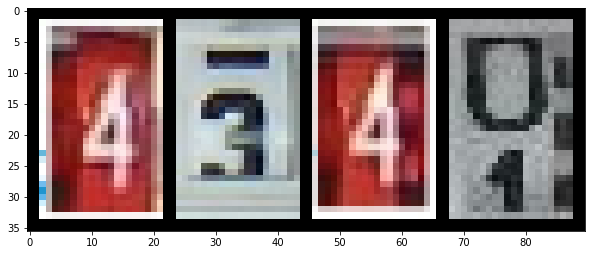

In [8]:
fp_images = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        for img, label in zip(images, labels):
            output = net(img.unsqueeze(0))
            predicted = torch.max(output, 1).indices[0].item()
            confidences = torch.nn.functional.softmax(output, 1).cpu().numpy()[0]
            if predicted != label:
                print("Predicted %d, Label %d, confidence %.2f %%, %s" % (predicted, label, 1e2 * confidences[predicted], ["%.1f %%" % (1e2 * c) for c in confidences]))
                fp_images.append(img.cpu())
  
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(fp_images, nrow=16))

# Save

In [9]:
print("Saved model accuracy: %.3f" % (best_model_accuracy))
torch.save(best_model, os.path.join("meter_digits_recognizer", "model_weights.pt"))

Saved model accuracy: 0.973
